# Visualizations and double checks for stimulus generation

This notebook should serve to document the key features of the stimulus that we generate

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import torch

## Simulus design key features to consider

1. We must do the rotation correctly, so that they all have the same frequency
2. We must center the grating on a peak (or valley) so that all angles have the same behavior around the center
3. We want the mean luminance of the stimuli to be constant in angle.
    - this can be achieved only up to the pixel discritization, so it depends on the resolution
    - in turn, the level of discritization error is also dependent on the frequency of the grating
        * but this will be aliased by the sampling, so workable frequencies are still set by the resolution


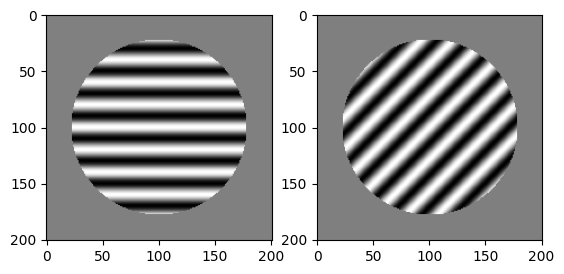

In [8]:
def getGrating(freq, theta, pixelDim=201):
    xs = np.linspace(-np.pi, np.pi, pixelDim)
    ys = np.linspace(-np.pi, np.pi, pixelDim)

    X, Y = np.meshgrid(xs, ys)
    Z = np.cos( freq * (Y*np.cos(theta) + X*np.sin(theta) ) )
    
    r2 = X**2 + Y**2
    Z[r2 >= 6] = 0
    
    return Z
    

Z1 = getGrating(10, 0, 201)
Z2 = getGrating(10, np.pi/4, 201)

plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(2*Z1-1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(2*Z2-1, cmap='gray')

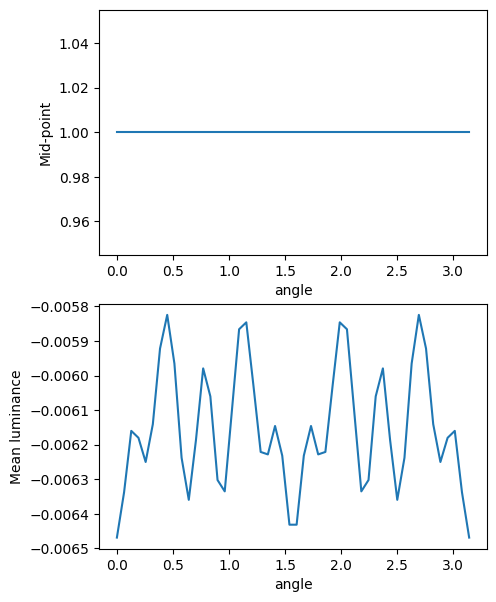

In [3]:
angles = np.linspace(0, np.pi, 50)

zeroPoint = []
means = []

for angle in angles:
    image = getGrating(10, angle, 201)
    means.append( np.mean(image) )
    
    zeroPoint.append(image[100,100])


figsize(5,7)  
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.plot(angles, np.array(zeroPoint))
plt.ylabel('Mid-point') 
plt.xlabel('angle') 

plt.subplot(2,1,2)
plt.plot(angles, np.array(means))
plt.xlabel('angle') 
plt.ylabel('Mean luminance');



## grating overlap as a means of assessing angle

It's very good at recovering the correct angle.

In [10]:
def findOverlap(grating1, grating2):
    return np.sum(grating1*grating2)
    
    

In [5]:
baseline = getGrating(10, np.pi/2)
angles = np.linspace(np.pi/2-0.001, np.pi/2+0.001, 300)

overlaps = []
for angle in angles:
    experimental = getGrating(10, angle)
    overlaps.append( findOverlap( baseline, experimental)  )
    

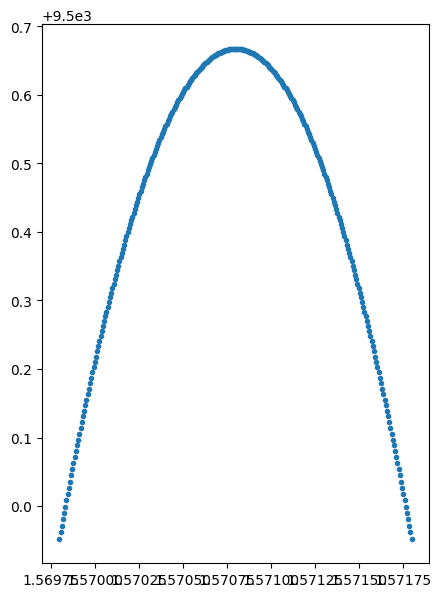

In [6]:
plt.plot(angles, np.array(overlaps), '.')

In [11]:
def searchForAngle(targetGrating, endpoints, targetResolution, makeGrating):
    """Perform repeatedly search for the max angle"""
    angles = np.linspace(endpoints[0], endpoints[1], 20)
    
    overlaps = []
    for angle in angles:
        test = makeGrating(angle)
        overlaps.append( findOverlap( targetGrating, test)  )
    
    maxInd = np.argmax( np.array(overlaps) )
    
    if endpoints[1] - endpoints[0] < targetResolution:
        return angles[maxInd]
    
    nextMin = angles[ max( maxInd-1, 0) ]
    nextMax = angles[ min( maxInd+1, len(angles)-1) ]
    
    return searchForAngle(targetGrating, [ nextMin, nextMax ] , targetResolution, makeGrating)
    
    
    
    

In [8]:
searchForAngle(getGrating(10, np.pi*3/4), [0, np.pi], 1E-5, lambda angle: getGrating(10, angle))

2.3561944857991075

We also need noise in our stimuli. Implemented in the file.

In [2]:
from stimulusGeneration import generateGrating

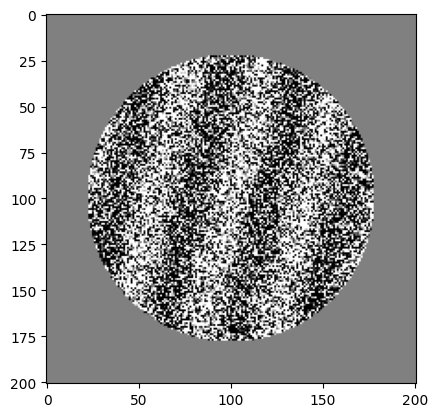

In [12]:
testimg = generateGrating([0.25], shotNoise=1.0, noiseVar=5.)
plt.imshow( testimg[0].detach(), cmap='gray' )

In [13]:
searchForAngle(testimg.numpy(), [0, np.pi], 1E-5, lambda angle: getGrating(10, angle))

2.9045451648944494

## Checking stimulus generation mod pi

In [12]:
from stimulusGeneration import GratingDataset

In [13]:
angles = np.linspace(0,2*np.pi, 20)
ds = GratingDataset(torch.tensor(angles) )
ds2 = GratingDataset(torch.tensor(angles) % np.pi)

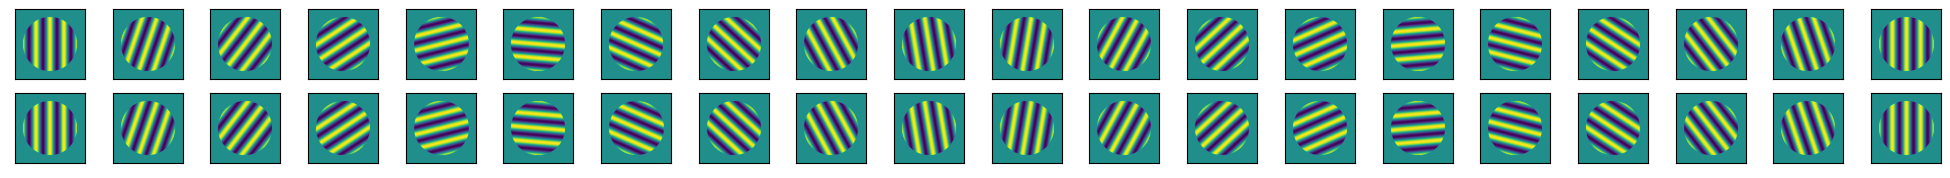

In [14]:
figsize(25,2)
plt.subplots(2,20)
for i in range(20):
    plt.subplot(2, 20,i+1)
    plt.imshow(ds.images[i,:,:].detach())
    plt.xticks([])
    plt.yticks([])
    
for i in range(20):
    plt.subplot(2, 20, i+21)
    plt.imshow(ds2.images[i,:,:].detach())
    plt.xticks([])
    plt.yticks([]) 
    
    


Ok, looks good. Staring at it for too long makes me wonder if they're the same, but I think it should be good to go

In [15]:
from scipy.stats import vonmises
samples = vonmises(1., 0).rvs(5000)

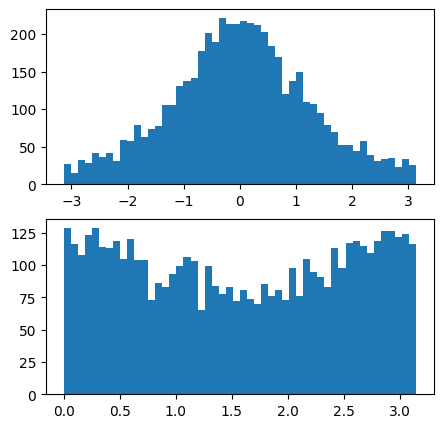

In [16]:
figsize(5,5)
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.hist(samples, bins=50);
plt.subplot(2,1,2)
plt.hist(samples % np.pi, bins=50);


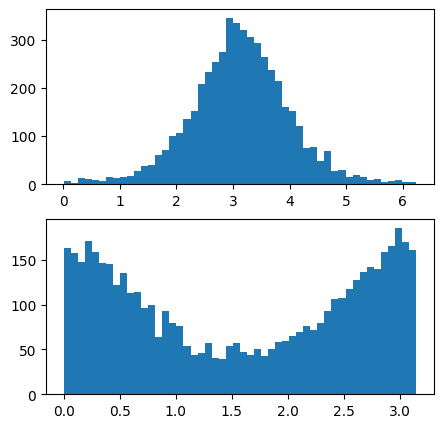

In [17]:
samples = vonmises(2., np.pi).rvs(5000)

figsize(5,5)
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.hist(samples, bins=50);
plt.subplot(2,1,2)
plt.hist(samples % np.pi, bins=50);


This is good, right? A distribution centered at 0 has peaks at both sides, as does on centered at $\pi$

$\pi + \alpha = \alpha \mod \pi $

$2\pi - \alpha = \pi- \alpha \mod \pi $

Note that the folding of the domain does make the variance half what it was.


## Question: how does recovery accuracy scale with resolution and noise?

Step one toward analysing fine tuning: find a parameter range that results in different training distribution dependent accuracy. In other words, is there a parameter range for which the training distribution actually matters? We want:

1. Resonable accuracy for networks trained around a given angle
2. Training mean dependent accuracy
3. Lower dimension is better for memory usage.



### Getting a feel for vonMises 

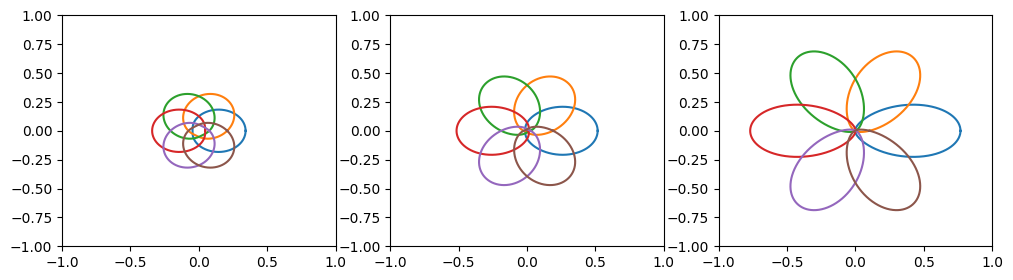

In [211]:
from scipy.stats import vonmises

thetas = np.linspace(0, 2*np.pi, 2000)

figsize( 12, 3)
plt.subplots(1,3)

for i, kappa in enumerate([1, 2, 4]):
    plt.subplot(1,3,i+1)
    for mean in np.linspace(0,2,7)[:-1]:
        pdf = vonmises(kappa, mean*np.pi).pdf(thetas)
        xs = pdf*np.cos(thetas)
        ys = pdf*np.sin(thetas)
        
        plt.plot(xs, ys)

        plt.xlim([-1,1])
        plt.ylim([-1,1])


This looks like a pretty good spectrum of to get started with.

### Getting a feel for different noise levels

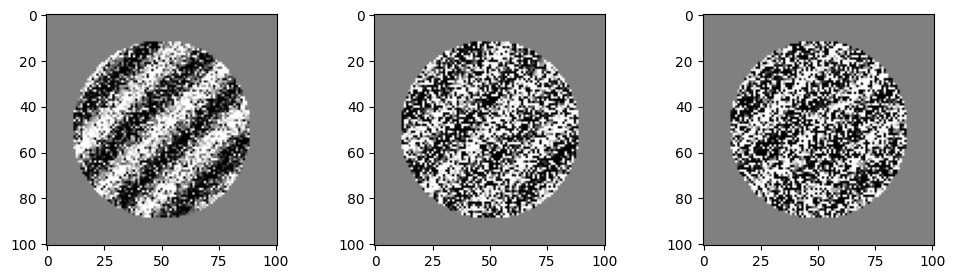

In [124]:
figsize( 12, 3)
plt.subplots(1,3)

for i, noiseLevel in enumerate([ 1., 10., 20.]):
    testimg = generateGrating([0.25*np.pi], pixelDim=101, shotNoise=0.8, noiseVar=noiseLevel)
    plt.subplot(1,3,i+1)
    plt.imshow( testimg[0].detach(), cmap='gray' )

#### How does the recovery performance scale with noisy levels?

For the control

In [204]:
from stimulusGeneration import generateGrating, searchForAngle

gratingGen = lambda angle: generateGrating(angle, pixelDim=101, shotNoise=0.)

observedDifferences = {0:[], 1:[], 2:[]}

for i, noiseLevel in enumerate([ 10., 20., 100.]):
    for trial in range(200):
        mean = np.pi*np.random.rand()
        testimg = generateGrating(mean, pixelDim=101, shotNoise=1., noiseVar=noiseLevel)

        reconstruction = searchForAngle(testimg, [0., np.pi], 1E-4, gratingGen)
        observedDifferences[i].append( mean - reconstruction)
        if trial%100==0:
            print(trial)
    print('noise level', i)
        

0
100
noise level 0
0
100
noise level 1
0
100
noise level 2


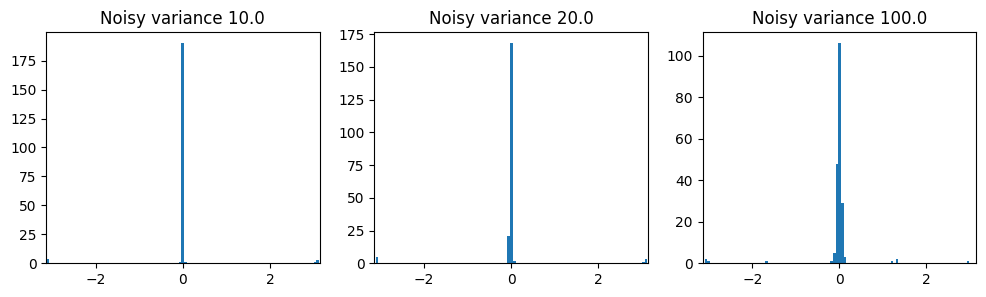

In [205]:
figsize( 12, 3)
plt.subplots(1,3)

for i, noiseLevel in enumerate([ 10., 20., 100.]):
    plt.subplot(1,3,i+1)
    plt.hist(observedDifferences[i], bins=101)
    plt.xlim([-np.pi, np.pi])
    plt.title(f'Noisy variance {noiseLevel}')


#### The positive control is _very_ good at cutting through noise.

Even in the above example, with 100% of pixels noisy and a very high noise variance, this model has little difficulty determining the angle. Example images are plotted below

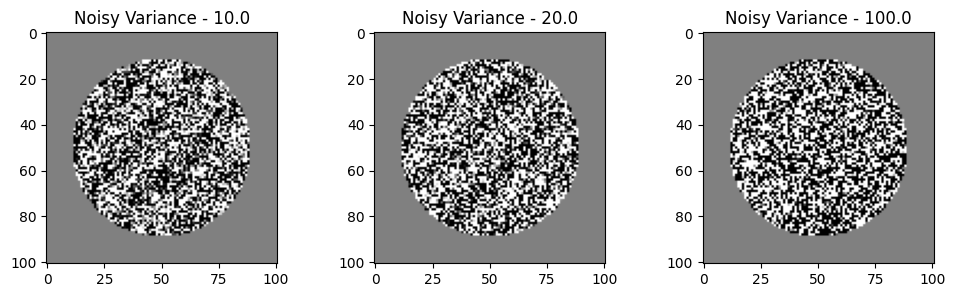

In [206]:
figsize( 12, 3)
plt.subplots(1,3)

for i, noiseLevel in enumerate([10., 20., 100.]):
    testimg = generateGrating([0.25*np.pi], pixelDim=101, shotNoise=1.0, noiseVar=noiseLevel)
    plt.subplot(1,3,i+1)
    plt.imshow( testimg[0].detach(), cmap='gray' )
    plt.title(f'Noisy Variance - {noiseLevel}')

So, the positive control beats even the human eye. How does it do this? I think this is because the pixel values are
$$
 \max( 0, \min( 1, v_{true} + \epsilon ) )
$$

Thus, the rounding preserves some value even when the variance is very large: $v_{true}$ determines the relative likelihood the pixel is rounded to 0 vs 1.

#### I don't expect the neural networks to perform anywhere close to this standard.